COLABTA ZİPTEKİ DOSYALARI ÇIKARTMA

In [1]:
import zipfile
import os

zip_file = "/content/drive/MyDrive/NewDataset.zip"
new_file_name = "newDataSet"

os.makedirs(new_file_name,exist_ok=True)

with zipfile.ZipFile(zip_file,"r") as zip_fol:
  zip_fol.extractall(new_file_name)

Kütüphane Entegrasyonları Ve Veri Etiketleme

In [16]:
import os
import pandas as pd
from pathlib import Path
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.utils import img_to_array,load_img
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")


def create_dataframe(directory):
    filepaths = []
    labels = []

    for label_dir in directory.iterdir():
        if label_dir.is_dir():
            label = label_dir.name
            for img_file in label_dir.iterdir():
                if img_file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                    filepaths.append(str(img_file))
                    labels.append(label)

    if not filepaths or not labels:
        raise ValueError("Filepaths or labels are empty.")
    if len(filepaths) != len(labels):
        raise ValueError("Filepaths and labels must have the same length.")

    data = {'Filepath': filepaths, 'Label': labels}
    df = pd.DataFrame(data)
    return df

base_dir = Path('/content/newDataSet/NewDataset')
train_dir = base_dir / "train"
test_dir = base_dir / "test"
df_test = create_dataframe(test_dir)
df_train = create_dataframe(train_dir)

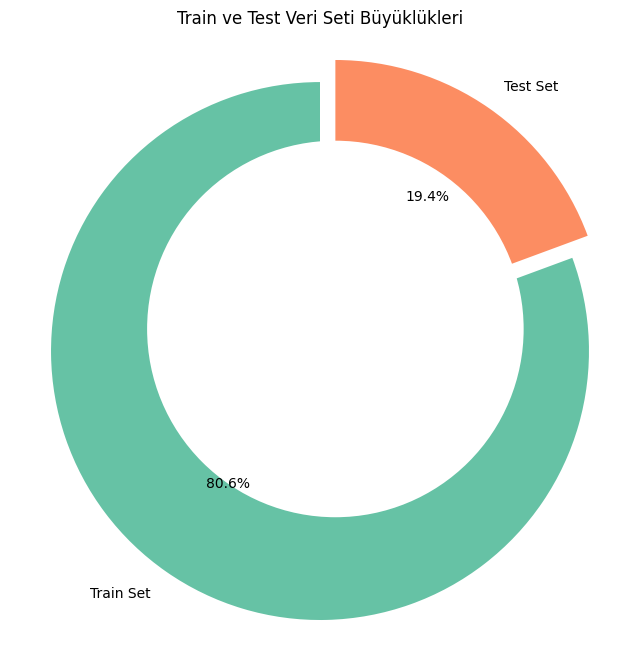

In [17]:
train_size = len(df_train)
test_size = len(df_test)

# Donut grafiği oluşturma
sizes = [train_size, test_size]
labels = ['Train Set', 'Test Set']
colors = ['#66c2a5', '#fc8d62']  # Renk paleti
explode = (0.1, 0)  # İlk dilimi biraz dışarı çıkartmak için

# Pasta grafiği oluştur
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%', startangle=90)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')  # İç kısım için beyaz daire
fig = plt.gcf()
fig.gca().add_artist(centre_circle)  # Daireyi ekle

plt.axis('equal')  # Eksenlerin eşit oranlı olmasını sağlar
plt.title('Train ve Test Veri Seti Büyüklükleri')
plt.show()

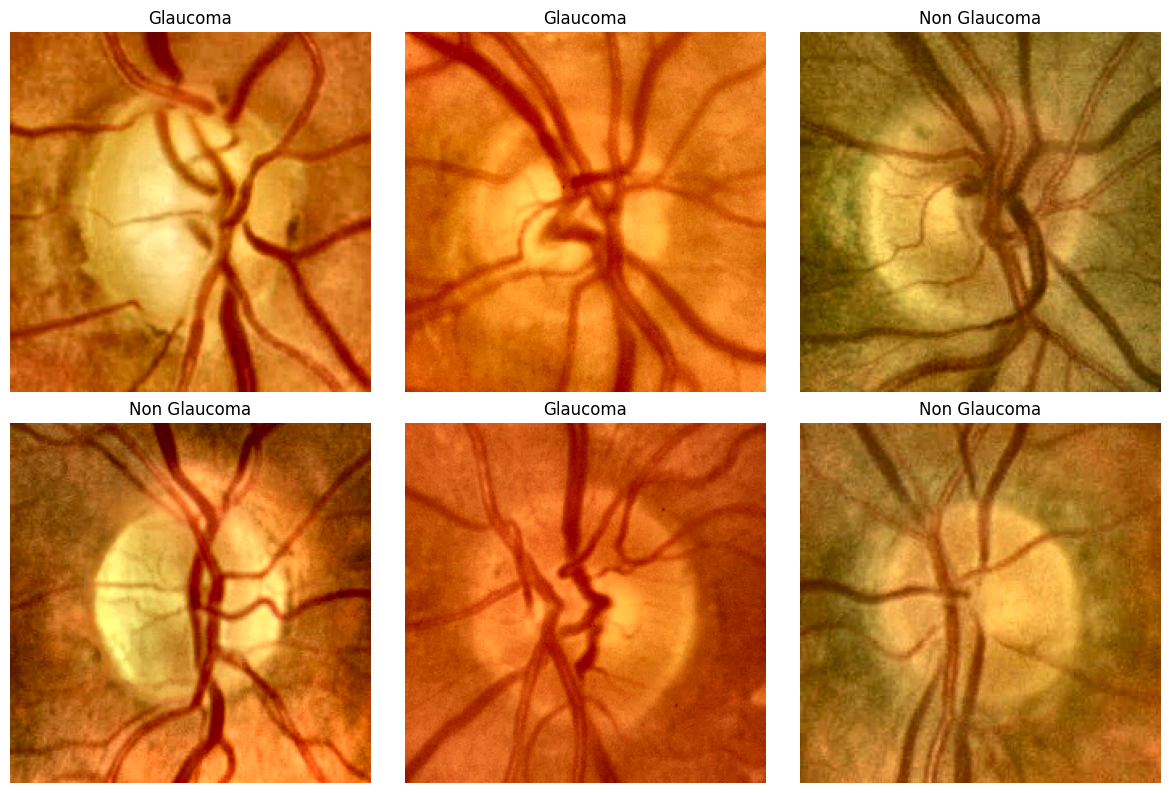

In [18]:
sample_images = df_test.sample(n=6, random_state=1)
plt.figure(figsize=(12, 8))
for i, (index, row) in enumerate(sample_images.iterrows()):
    img = plt.imread(row['Filepath'])
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(row['Label'])
    plt.axis('off')
plt.tight_layout()
plt.show()

VERİ ARTIRMA VE DATAGEN TÜRÜNE ÇEVİRME KISMI

In [19]:

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='Filepath',
    y_col='Label',
    color_mode='rgb',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
)

test_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='Filepath',
    y_col='Label',
    class_mode='categorical',
    target_size=(224, 224),
    batch_size=16,
    shuffle=False
)

print(train_generator)
print(test_generator)

Found 791 validated image filenames belonging to 2 classes.
Found 190 validated image filenames belonging to 2 classes.


In [ ]:

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
# Önceden eğitilmiş katmanları dondurmayınca %92 ama aşırı öğrenme olmaması adına False yapıyorum normalde

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1028, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))


num_classes = len(df_train['Label'].unique())
model.add(Dense(num_classes, activation='softmax'))

optimizer=Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-7)

model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

model.summary

model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=40
)

loss, accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")



test_labels = test_generator.classes

predictions = model.predict(test_generator, steps=len(test_generator))
predicted_classes = np.argmax(predictions, axis=1)

cm = confusion_matrix(test_labels, predicted_classes)
print("Confusion Matrix:")
print(cm)

report = classification_report(test_labels, predicted_classes, target_names=test_generator.class_indices.keys())
print("Classification Report:")
print(report)

Epoch 1/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.5882 - loss: 0.7455
Epoch 2/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 264ms/step - accuracy: 0.7663 - loss: 0.4922
Epoch 4/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 267ms/step - accuracy: 0.7855 - loss: 0.4543
Epoch 6/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 264ms/step - accuracy: 0.8200 - loss: 0.4142
Epoch 8/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 269ms/step - accuracy: 0.8227 - loss: 0.3931
Epoch 10/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 262ms/step - accuracy: 0.8512 - loss: 0.3507
Epoch 12/4